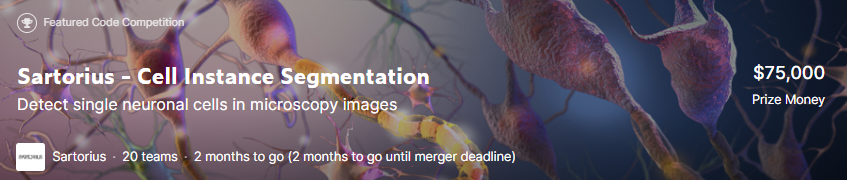

## What is written here is just the Japanese version of the content written in kaggle, so it is not written in English.

> 現在のソリューションでは、特に神経細胞の精度が制限されています。細胞インスタンスセグメンテーションモデルを開発するための内部研究では、神経芽細胞腫細胞株SH-SY5Yは、テストされた8つの異なる癌細胞タイプの中で一貫して最低の精度スコアを示しています。これは、神経細胞が非常に独特で不規則で凹状の形態を持っており、一般的に使用されているマスクヘッドでセグメント化するのが難しいためである可能性があります。
> 
> ザルトリウスは、ライフサイエンス研究とバイオ医薬品業界のパートナーです。それらは、科学者やエンジニアがライフサイエンスとバイオプロセシングの進歩を簡素化および加速することを可能にし、新しくより良い治療法とより手頃な価格の医療の開発を可能にします。これらは、この分野のパイオニアや一流の専門家にとって魅力的でダイナミックなプラットフォームです。彼らは、より多くの人々のより良い健康につながる技術的進歩という共通の目標のために創造的な心を結集します。
> 
> <u>このコンテストでは、神経障害の研究で一般的に使用される神経細胞の種類を描いた生物学的画像で、関心のある個別のオブジェクトを検出して描写します。具体的には、位相差顕微鏡画像を使用して、神経細胞のセグメンテーションなどのモデルをトレーニングおよびテストします。成功したモデルは、これを高レベルの精度で実行します。</u>
> 
> 成功した場合は、堅牢な定量的データの収集のおかげで、神経生物学のさらなる研究を支援します。研究者はこれを使用して、神経細胞に対する疾患や治療条件の影響をより簡単に測定できる可能性があります。その結果、これらの主要な死因と障害を持つ何百万人もの人々を治療するための新薬が発見される可能性があります。

> このコンテストでは、画像内の神経細胞をセグメント化します。トレーニングアノテーションはランレングスエンコードされたマスクとして提供され、画像はPNG形式です。画像の数は少ないですが、注釈付きのオブジェクトの数はかなり多いです。非表示のテストセットは約240枚の画像です。
> 
> ファイル
> train.csv-すべてのトレーニングオブジェクトのIDとマスク。このメタデータはいずれもテストセットには提供されていません。
> 
> id-オブジェクトの一意の識別子
> 
> 注釈-識別された神経細胞のランレングスエンコードされたピクセル
> 
> width-ソース画像の幅
> 
> height-ソース画像の高さ
> 
> cell_type-細胞株
> 
> plate_time-タイムプレートが作成された時間
> 
> sample_date-サンプルが作成された日付
> 
> sample_id-サンプル識別子
> 
> 経過時間デルタ-サンプルの最初の画像が撮影されてからの時間
> 
> sample_submission.csv-正しい形式のサンプル送信ファイル
> 
> train-PNG形式で画像をトレーニングする
> 
> test-PNG形式の画像をテストします。ダウンロードできるテストセットの画像はごくわずかです。残りの部分は、送信時にノートブックからのみアクセスできます。
> 
> train_semi_supervised-半教師ありアプローチに追加データを使用する場合に提供されるラベルなし画像。==>どうやって使えばいいのか👎
> 
> LIVECell_dataset_2021-LIVECellデータセットからのデータのミラー。 LIVECellは、この競争の前身のデータセットです。 SH-SHY5Y細胞株の追加データに加えて、競合データセットに含まれていない、転移学習に役立つ可能性のある他のいくつかの細胞株があります。👎=>これも大量のデータがありますが、どうすればいいのか。現在読み解けていません。はい。

### コンペの提出期限がせまってきたので、ここからまじめにとりくんでいきます。<br>
### セマンティックセグメンテーションはやったことがないので、どういう対応がいいのか考えていきましょう。<br>
### Masked R-CNNとDetectron2が人気のようです。

<br>

### The deadline for submitting the competition has come to an end, so I will start seriously from here. <br>
### I've never done semantic segmentation, so let's think about what to do. <br>
### Masked R-CNN and Detectron 2 seem to be popular.

In [ ]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
import warnings
from PIL import Image, ImageFilter
warnings.simplefilter('ignore')

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Train data read</span>

トレインデータには、データのID(画像と紐づけられている）と、アノテーション（※）、画像サイズ、タイプなどの情報があります。<br>
このアノテーションが重要で、例えば一行目の118145 6は、118145の位置（つまり、118145/704(width)=167(縦) 118145 -(704*167)=577(横）<br>
つまり、縦 167,横577　の位置から6バイトの長さの位置ということになります。<br>
また、みてわかるように同じidが並んでいます。id 1つに複数の行のアノテーション情報が与えられています。<br>
挑戦するのは、この情報を学習し、与えられたテストデータのアノテーションを予測することが、今回の課題です。<br>
今までやってきた、画像認識、物体検知はbbox単位でやってきましたが、これはセマンティックアノテーションです。これが難しいところです。

Train data includes data ID (linked to the image), annotation (*), image size, type, and other information. <br>
This annotation is important, for example, 118145 6 on the first line is the position of 118145 (that is, 118145/704 (width) = 167 (vertical) 118145-(704 * 167) = 577 (horizontal) <br>
In other words, it is a position 6 bytes long from the position of 167 in the vertical direction and 577 in the horizontal direction. <br>
Also, as you can see, the same ids are lined up. Multiple lines of annotation information are given to one id. <br>
The challenge is to learn this information and predict the annotation of the given test data. <br>
Image recognition and object detection, which have been done so far, have been done in bbox units, but this is a semantic annotation. This is the difficult part.

In [ ]:
train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
train

In [ ]:
len(train.id.unique())

### トレインデータのidは606個あるということがわかります。

### You can see that there are 606 ids of train data.

In [ ]:
len(train.sample_id.unique())

### sample_idは403種類あることがわかります。

### You can see that there are 403 types of sample_id.

In [ ]:
a =train[train.id =='0030fd0e6378']
a

### 1つのID(0030fd0e6378)に395行のアノテーションが紐づいていることがわかります。

### You can see that one ID (0030fd0e6378) is associated with 395 lines of annotation.

In [ ]:
a.sample_id.unique()

In [ ]:
train.cell_type.unique()

### cell_typeは3種類(shsy5y', 'astro', 'cort')ということがわかります。

### You can see that there are 3 types of ### cell_type (shsy5y','astro','cort').

In [ ]:
train['file_path'] =train['id'].apply(lambda x: '../input/sartorius-cell-instance-segmentation/train/{}.png'.format(x))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">なにも考えずにただ１つ読む</span><br>
<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Read only one without thinking</span>

In [ ]:
im = np.array(Image.open(train.loc[0,'file_path']))
plt.imshow(im)

### なにかがありますが、なんだかわかりにくいですね。でも、これが問題の画像です。答えと後で紐づけて表示させます。
### そうすると、この問題の画像の味方が少しわかる気がします。気のせいかもしれませんが。

### There is something, but it's kind of hard to understand. But this is the image in question. The answer will be linked and displayed later.
### Then, I feel that I can understand a little about the side of the image in this problem. Maybe it's because of my mind.

In [ ]:
im.shape

### 実際のファイルの大きさと、trainデータのheight,widthと一緒ですね。

### It's the same as the actual file size and the height and width of the train data.

In [ ]:
def get_image(path):
    image = np.array(Image.open(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_annot(img_id):
    return train[train.id == img_id].annotation.values

def get_mask(img_annotations): 
    mask = np.zeros((520, 704, 3))
    for annot in img_annotations:
        mask += rle_decode(annot, shape=(520, 704, 3))
    mask = mask.clip(0, 1)
    return mask

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

### rle_decodeがやっていることを実データを入れて動きをみていきましょう。

### Let's see what rle_decode is doing with real data.

In [ ]:
mask_rle = train.loc[0,'annotation']
s = mask_rle.split()
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

### アノテーションデータを入れています。

### Contains annotation data.

In [ ]:
mask_rle

### アノテーションデータのスタート位置、長さを分離しています。

### The start position and length of annotation data are separated.

In [ ]:
starts,lengths

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">アノテーションデータをマスクとして表示</span><br>
<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Display annotation data as a mask</span>

In [ ]:
plt.imshow(get_mask(get_annot(train.loc[0,'id'])));

元画像に、アノテーションデータをかぶせるとこの画像になります。全然違うイメージになりますね。これを予想するモデルを作ることになります。
なんて難しい問題なんだ。

If you cover the original image with annotation data, it will be this image. It will be a completely different image. You will create a model that anticipates this.
What a difficult problem!

### １枚だけだとよくわからないので、20種類読んでアノテーションデータを組み合わせて表示させます。

### I'm not sure if there is only one sheet, so I read 20 types and display them in combination with annotation data.

In [ ]:
idu = train.id.unique()
idu[:20]

In [ ]:
import glob
fig = plt.figure(figsize=(30,20))
x=1
for i in range(20):
    #im = np.array(Image.open(train.loc[i,'file_path']))
    fig.add_subplot(4, 5, x)
    #mask_rle = train.loc[i,'annotation']
    #s = mask_rle.split()
    #starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    plt.title(idu[i])
    plt.imshow(get_mask(get_annot(idu[i])))
    x+=1

In [ ]:
sub = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
sub

### テストデータは、たった３ファイル！！パブリックのテストデータはきっとでかいと思います。

### Test data is only 3 files! !! I'm sure the public test data is huge.

### いつも失敗するのが、シェアされているコードをちょっといじってやった気になってしまうこと。
### これ最悪です。なにも学んでない上に、スコアも平凡なものになり、なんにもならない。
### まじめに取り組むのが一番近道だと思っています。無駄になることも多いですが。

### The thing that always fails is that you feel like playing around with the shared code.
### This is the worst. I haven't learned anything, and my score is mediocre, and nothing happens.
### I think the quickest way is to work seriously. It's often wasted.

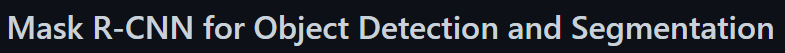

### スクラッチで作る場合、次の順番でやっていくそうです。すごい大変そうだなあ。でもコンペではbboxやマスクは作られているので違うアプローチが必要ですね<br>

 1.アンカーの並べ替えとフィルタリング<br>
 2.バウンディングボックスの改良<br>
 3.マスクの生成<br>
 4.レイヤーのアクティブ化<br>
 5.重量ヒストグラム<br>
 6.さまざまな部分を構成して最終結果を得る<br>

### When making with scratch, it seems to go in the following order. It looks like it's going to be really hard. But in the competition, bboxes and masks are made, so a different approach is needed. <br>

 1. Anchor sorting and filtering<br>
 2. Bounding Box Refinement<br>
 3. Mask Generation<br>
 4. Layer activations<br>
 5. Weight Histograms<br>
 6. Composing the different pieces into a final result<br>

どうも探していくうちに古いカグルのコンペがヒットした。
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

U-Net：生物医学画像セグメンテーションのための畳み込みネットワークに大まかに基づいており、Kaggle超音波神経セグメンテーションコンペティションのこのリポジトリに非常によく似たU-Netモデルを構築します。<br>
なんか今回のコンペとかなり近い気がします。

we build our U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation and very similar to this repo from the Kaggle Ultrasound Nerve Segmentation competition.<br>
I feel that it is quite close to this competition.

### U-netのモデル

### U-net model

https://arxiv.org/abs/1505.04597

通常、畳み込みニューラルネットワークは、単一のクラスラベルを入力画像に出力する分類タスクで使用されます。多くの場合、出力にはローカリゼーションが必要です。ローカリゼーションとは、クラスラベルが各ピクセルに割り当てられることを意味します。セマンティックセグメンテーションに慣れていない場合でも心配はいりません。それは素晴らしい。

Convolutional neural networks are typically used in classification tasks that output a single class label to the input image. Output often requires localization. Localization means that a class label is assigned to each pixel. If you're new to semantic segmentation, don't worry. It's great.

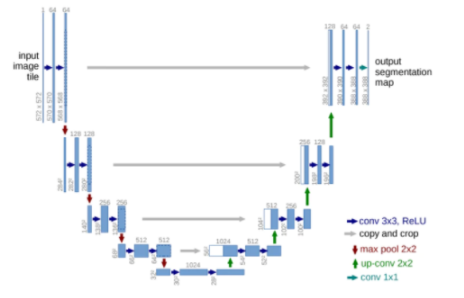

概要を把握するために、左上に入力画像、右上に出力セグメンテーションマップがあります

最初に画像がダウンサンプリングされる収縮パス（アーキテクチャの左側）があり、次に画像がアップサンプリングされる拡張パス（アーキテクチャの右側）があります。また、これらの収縮と拡張パスの間に、スキップ接続があります。なぜこれらのスキップ接続があるのかを見ていきます。

To get an overview, there is an input image in the upper left and an output segmentation map in the upper right.

First there is a shrink path where the image is downsampled (on the left side of the architecture), then there is an extended path where the image is upsampled (on the right side of the architecture). There is also a skip connection between these contractions and expansion paths. Let's see why there are these skip connections.

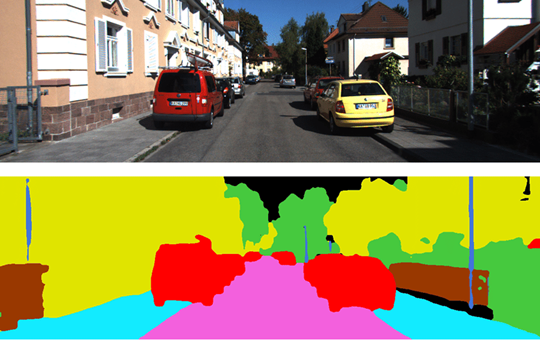

2つの3x3畳み込みを使用し、機能チャネルの数を64にした後、ダウンサンプリングを担当するカーネルサイズ2とストライド2の最大プーリングが続きます。彼らは、最終的にアップサンプリングの実行を開始するまで、毎回機能チャネルの数を2倍にする同じアプローチを使用します。拡張パスでは、Conv2DTransposeを使用して画像をアップサンプリングします。スキップ接続（灰色の矢印、図2）を使用し、画像をアップサンプリングするたびにチャネルの寸法に沿って連結します。彼らは再び2つの3x3畳み込みを使用し、機能の数は512で、その後アップサンプリングします。収縮パスとは異なり、画像をアップサンプリングするたびに、ここでは機能チャネルの数が半分になります。最終層では、追加の1x1 convを1つ使用して、チャネル数を所有しているクラスの数（この場合は2）に変更します。

It uses two 3x3 convolutions, has 64 functional channels, and is followed by maximum pooling of kernel size 2 and stride 2 responsible for downsampling. They use the same approach of doubling the number of functional channels each time until they finally start performing upsampling. The extended path uses Conv2DTranspose to upsample the image. Use the skip connection (gray arrow, Figure 2) to concatenate along the dimensions of the channel each time you upsample the image. They again use two 3x3 convolutions, have a number of features of 512, and then upsample. Unlike the shrink path, each time you upsample the image, the number of functional channels is halved here. The final tier uses one additional 1x1 conv to change the number of channels to the number of classes that own it (2 in this case).

U-Netのダウン部分を作成します。以前に定義されたクラス、つまりDoubleConvを使用して作成し、in_channelsとout_channelsに言及します。次に、U-Netのアップ部分を実行し、アップ部分で機能チャネルが逆になっていることを確認します。また、アップサンプリングにConvTranspose2Dを使用し、次にDoublConvを使用します。チャネル次元に沿ってスキップ接続を連結するため、in_channelsをfeature * 2に設定します。ボトルネック、つまりアーキテクチャの最下部を作成し、次に最終出力レイヤー）を作成してチャネル数を変更します。

Create the down part of U-Net. Created using a previously defined class, DoubleConv, and mentions in_channels and out_channels. Next, run the up part of the U-Net and make sure that the functional channels are reversed in the up part. Also, use ConvTranspose2D for upsampling, then DoublConv. Set in_channels to feature * 2 to concatenate skip connections along the channel dimension. Create a bottleneck, the bottom of the architecture, then the final output layer) to change the number of channels.

# Discuttion

ヒント
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/281205<br>
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/284062<br>
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279996<br>

<pre>
・このコンテストのタスクは「セマンティックセグメンテーション」ではなく「インスタンスセグメンテーション」です。 したがって、セルマスクを個別に予測する必要があります。 私の第一印象は、U-Netや何かセマンティックセグメンテーションモデルを使用するよりも、マスクRCNNのようなインスタンスセグメンテーションモデルを使用する方が良いということです。 LBで0.22以上のスコアを獲得した私のベースモデルは、一種のマスクRCNNです。
・提出時には、マスクをエンコードする必要があります。評価ページには、ピクセルが上から下、次に左から右に番号が付けられていることが示されています。しかし、これは正しくありません。ご存知のように、提供されるトレーニングアノテーションは左から右、次に上から下に番号が付けられています。これは提出の場合にも当てはまります。
エンコードされたマスク（上->下、左->右）のLBスコアは0.0000でしたが、（左->右、上->下）のスコアは0.22を超えていました。

-The task of this contest is not "semantic segmentation" but "instance segmentation". Therefore, the cell mask must be predicted individually. My first impression is that it's better to use an instance segmentation model like Mask RCNN than to use U-Net or any semantic segmentation model. My base model with a score of 0.22 or higher in LB is a kind of mask RCNN.
-When submitting, the mask must be encoded. The rating page shows that the pixels are numbered from top to bottom and then from left to right. But this is not correct. As you know, the training annotations provided are numbered from left to right, then top to bottom. This is also true for submissions.
The encoded mask (top-> bottom, left-> right) had an LB score of 0.0000, while the (left-> right, top-> bottom) score was above 0.22.

😺😅㊙🔰🗑⬛🟥🟨🟩